In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.001
num_episodes = 50000
gamma=0.999999
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 50000

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=500000

batch_size=32

update_target_frequency = 100000

clip_error=False

In [9]:
env = gym.make('Breakout-ramDeterministic-v4')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout_DQN_p1',video_callable=lambda episode_id: episode_id%100==0,force=True)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [15]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
        new_state_values=self.target_nn(new_state).detach()
        #print('shape of: new_state_values')
        #print(new_state_values.shape)
        
        max_new_state_values=torch.max(new_state_values,dim=1)[0]
        #print('shape of: max_new_state_values')
        #print(max_new_state_values.shape)
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [16]:
a=torch.randn([3,3])
print(a)

tensor([[-0.7110, -1.7128,  1.4045],
        [-1.2435, -1.1823, -0.6999],
        [-0.8892, -0.1705, -0.7279]])


In [17]:
a.clamp_(-1.0,1.0)

tensor([[-0.7110, -1.0000,  1.0000],
        [-1.0000, -1.0000, -0.6999],
        [-0.8892, -0.1705, -0.7279]])

In [18]:
a

tensor([[-0.7110, -1.0000,  1.0000],
        [-1.0000, -1.0000, -0.6999],
        [-0.8892, -0.1705, -0.7279]])

In [19]:
memory=ExperienceReplay(replay_memory_size)

In [20]:
qnet_agent=QNet_Agent()

In [21]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [22]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 1.3
Average over all episodes so far: 1.3
epsilon: 0.8639233731106812
**** Episode  20 **** 
Recent average reward: 1.0
Average over all episodes so far: 1.15
epsilon: 0.8350149131577789
**** Episode  30 **** 
Recent average reward: 1.3
Average over all episodes so far: 1.2
epsilon: 0.804776913023483
**** Episode  40 **** 
Recent average reward: 0.9
Average over all episodes so far: 1.125
epsilon: 0.7772106941957513
**** Episode  50 **** 
Recent average reward: 1.2
Average over all episodes so far: 1.14
epsilon: 0.7491652158395632
**** Episode  60 **** 
Recent average reward: 0.9
Average over all episodes so far: 1.1
epsilon: 0.7240417704978165
**** Episode  70 **** 
Recent average reward: 1.1
Average over all episodes so far: 1.1
epsilon: 0.6990414733380943
**** Episode  80 **** 
Recent average reward: 1.7
Average over all episodes so far: 1.175
epsilon: 0.6723283717085857
**** Episode  90 **** 
Recent average reward: 0.8
Average over all 

**** Episode  560 **** 
Recent average reward: 1.2
Reward over last 100: 1.18
Average over all episodes so far: 1.2321428571428572
epsilon: 0.1107700776366514
**** Episode  570 **** 
Recent average reward: 1.5
Reward over last 100: 1.25
Average over all episodes so far: 1.236842105263158
epsilon: 0.10680914497729481
**** Episode  580 **** 
Recent average reward: 1.6
Reward over last 100: 1.32
Average over all episodes so far: 1.243103448275862
epsilon: 0.102873788888944
**** Episode  590 **** 
Recent average reward: 1.5
Reward over last 100: 1.32
Average over all episodes so far: 1.2474576271186442
epsilon: 0.09896130169216262
**** Episode  600 **** 
Recent average reward: 1.2
Reward over last 100: 1.36
Average over all episodes so far: 1.2466666666666666
epsilon: 0.0955688626364665
**** Episode  610 **** 
Recent average reward: 1.0
Reward over last 100: 1.4
Average over all episodes so far: 1.2426229508196722
epsilon: 0.09209699899343596
**** Episode  620 **** 
Recent average reward: 

**** Episode  1080 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.387037037037037
epsilon: 0.02065214694295149
**** Episode  1090 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.391743119266055
epsilon: 0.020227717765274336
**** Episode  1100 **** 
Recent average reward: 1.0
Reward over last 100: 1.62
Average over all episodes so far: 1.3881818181818182
epsilon: 0.019818235900806797
**** Episode  1110 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.3891891891891892
epsilon: 0.01939841880343549
**** Episode  1120 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.3901785714285715
epsilon: 0.01900609403075721
**** Episode  1130 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.3902654867256636
epsilon: 0.018623589926127386
**** Episode  1140 **** 
Recent av

**** Episode  1590 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.4578616352201257
epsilon: 0.011110334657054372
**** Episode  1600 **** 
Recent average reward: 2.4
Reward over last 100: 1.6
Average over all episodes so far: 1.46375
epsilon: 0.011057704995924813
**** Episode  1610 **** 
Recent average reward: 2.2
Reward over last 100: 1.67
Average over all episodes so far: 1.4683229813664596
epsilon: 0.011011567858855311
**** Episode  1620 **** 
Recent average reward: 0.7
Reward over last 100: 1.54
Average over all episodes so far: 1.4635802469135804
epsilon: 0.01097256483505592
**** Episode  1630 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.463803680981595
epsilon: 0.0109315936685867
**** Episode  1640 **** 
Recent average reward: 1.2
Reward over last 100: 1.46
Average over all episodes so far: 1.4621951219512195
epsilon: 0.010893473559142981
**** Episode  1650 **** 
Recent average rewa

**** Episode  2110 **** 
Recent average reward: 1.5
Reward over last 100: 1.98
Average over all episodes so far: 1.5260663507109005
epsilon: 0.010106795601552037
**** Episode  2120 **** 
Recent average reward: 1.2
Reward over last 100: 1.91
Average over all episodes so far: 1.5245283018867926
epsilon: 0.010102550641676835
**** Episode  2130 **** 
Recent average reward: 0.8
Reward over last 100: 1.78
Average over all episodes so far: 1.5211267605633803
epsilon: 0.010098762377895995
**** Episode  2140 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5219626168224298
epsilon: 0.010094263753527986
**** Episode  2150 **** 
Recent average reward: 2.0
Reward over last 100: 1.71
Average over all episodes so far: 1.524186046511628
epsilon: 0.010089867534004452
**** Episode  2160 **** 
Recent average reward: 1.9
Reward over last 100: 1.75
Average over all episodes so far: 1.525925925925926
epsilon: 0.010085784363106467
**** Episode  2170 **** 
Recen

**** Episode  2620 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.5580152671755725
epsilon: 0.0100109042949279
**** Episode  2630 **** 
Recent average reward: 0.5
Reward over last 100: 1.5
Average over all episodes so far: 1.5539923954372623
epsilon: 0.01001050505680501
**** Episode  2640 **** 
Recent average reward: 2.0
Reward over last 100: 1.51
Average over all episodes so far: 1.5556818181818182
epsilon: 0.010010012524323535
**** Episode  2650 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.5554716981132075
epsilon: 0.010009594372625037
**** Episode  2660 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.556390977443609
epsilon: 0.0100091406979227
**** Episode  2670 **** 
Recent average reward: 2.7
Reward over last 100: 1.72
Average over all episodes so far: 1.560674157303371
epsilon: 0.010008722420168814
**** Episode  2680 **** 
Recent aver

**** Episode  3130 **** 
Recent average reward: 1.0
Reward over last 100: 1.64
Average over all episodes so far: 1.5811501597444089
epsilon: 0.010001096931505913
**** Episode  3140 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.5828025477707006
epsilon: 0.01000104399713135
**** Episode  3150 **** 
Recent average reward: 2.6
Reward over last 100: 1.83
Average over all episodes so far: 1.5860317460317461
epsilon: 0.010000994253317423
**** Episode  3160 **** 
Recent average reward: 1.7
Reward over last 100: 1.81
Average over all episodes so far: 1.5863924050632912
epsilon: 0.010000950465648374
**** Episode  3170 **** 
Recent average reward: 1.7
Reward over last 100: 1.81
Average over all episodes so far: 1.586750788643533
epsilon: 0.010000907970619493
**** Episode  3180 **** 
Recent average reward: 1.3
Reward over last 100: 1.76
Average over all episodes so far: 1.5858490566037735
epsilon: 0.010000871026168576
**** Episode  3190 **** 
Recen

**** Episode  3640 **** 
Recent average reward: 1.3
Reward over last 100: 1.85
Average over all episodes so far: 1.620054945054945
epsilon: 0.010000106419839469
**** Episode  3650 **** 
Recent average reward: 1.8
Reward over last 100: 1.78
Average over all episodes so far: 1.6205479452054794
epsilon: 0.01000010193873756
**** Episode  3660 **** 
Recent average reward: 1.8
Reward over last 100: 1.76
Average over all episodes so far: 1.6210382513661201
epsilon: 0.010000097408358256
**** Episode  3670 **** 
Recent average reward: 0.9
Reward over last 100: 1.63
Average over all episodes so far: 1.6190735694822889
epsilon: 0.01000009357394887
**** Episode  3680 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.6195652173913044
epsilon: 0.010000089483300447
**** Episode  3690 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.619241192411924
epsilon: 0.010000085453470291
**** Episode  3700 **** 
Recent 

**** Episode  4150 **** 
Recent average reward: 1.7
Reward over last 100: 1.88
Average over all episodes so far: 1.6467469879518073
epsilon: 0.010000010435276324
**** Episode  4160 **** 
Recent average reward: 1.5
Reward over last 100: 1.87
Average over all episodes so far: 1.6463942307692307
epsilon: 0.010000010005470773
**** Episode  4170 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.6458033573141486
epsilon: 0.01000000958857246
**** Episode  4180 **** 
Recent average reward: 2.5
Reward over last 100: 1.81
Average over all episodes so far: 1.647846889952153
epsilon: 0.010000009099250256
**** Episode  4190 **** 
Recent average reward: 1.9
Reward over last 100: 1.78
Average over all episodes so far: 1.6484486873508353
epsilon: 0.010000008669161044
**** Episode  4200 **** 
Recent average reward: 1.6
Reward over last 100: 1.8
Average over all episodes so far: 1.6483333333333334
epsilon: 0.010000008279909354
**** Episode  4210 **** 
Recent

**** Episode  4660 **** 
Recent average reward: 1.8
Reward over last 100: 2.16
Average over all episodes so far: 1.6648068669527898
epsilon: 0.0100000009839817
**** Episode  4670 **** 
Recent average reward: 2.2
Reward over last 100: 2.03
Average over all episodes so far: 1.6659528907922911
epsilon: 0.010000000940119786
**** Episode  4680 **** 
Recent average reward: 1.8
Reward over last 100: 2.01
Average over all episodes so far: 1.6662393162393163
epsilon: 0.010000000900227311
**** Episode  4690 **** 
Recent average reward: 2.3
Reward over last 100: 2.07
Average over all episodes so far: 1.667590618336887
epsilon: 0.010000000859221975
**** Episode  4700 **** 
Recent average reward: 1.6
Reward over last 100: 2.07
Average over all episodes so far: 1.6674468085106382
epsilon: 0.010000000821052702
**** Episode  4710 **** 
Recent average reward: 1.8
Reward over last 100: 2.11
Average over all episodes so far: 1.667728237791932
epsilon: 0.010000000783575406
**** Episode  4720 **** 
Recent 

**** Episode  5170 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.676982591876209
epsilon: 0.010000000096834884
**** Episode  5180 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.677027027027027
epsilon: 0.010000000092662819
**** Episode  5190 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.6772639691714837
epsilon: 0.010000000088410196
**** Episode  5200 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.6775
epsilon: 0.010000000084817958
**** Episode  5210 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.6775431861804222
epsilon: 0.010000000081155518
**** Episode  5220 **** 
Recent average reward: 1.3
Reward over last 100: 1.59
Average over all episodes so far: 1.6768199233716474
epsilon: 0.010000000077993641
**** Episode  5230 **** 
Recent average re

**** Episode  5680 **** 
Recent average reward: 1.8
Reward over last 100: 1.87
Average over all episodes so far: 1.6963028169014085
epsilon: 0.0100000000091218
**** Episode  5690 **** 
Recent average reward: 1.8
Reward over last 100: 1.88
Average over all episodes so far: 1.6964850615114235
epsilon: 0.010000000008721989
**** Episode  5700 **** 
Recent average reward: 1.6
Reward over last 100: 1.9
Average over all episodes so far: 1.6963157894736842
epsilon: 0.010000000008336198
**** Episode  5710 **** 
Recent average reward: 1.2
Reward over last 100: 1.84
Average over all episodes so far: 1.695446584938704
epsilon: 0.010000000007966197
**** Episode  5720 **** 
Recent average reward: 2.1
Reward over last 100: 1.83
Average over all episodes so far: 1.6961538461538461
epsilon: 0.010000000007609422
**** Episode  5730 **** 
Recent average reward: 2.1
Reward over last 100: 1.89
Average over all episodes so far: 1.6968586387434554
epsilon: 0.01000000000725454
**** Episode  5740 **** 
Recent a

**** Episode  6190 **** 
Recent average reward: 1.7
Reward over last 100: 1.92
Average over all episodes so far: 1.7064620355411955
epsilon: 0.010000000000894195
**** Episode  6200 **** 
Recent average reward: 2.4
Reward over last 100: 1.98
Average over all episodes so far: 1.7075806451612903
epsilon: 0.010000000000849886
**** Episode  6210 **** 
Recent average reward: 1.5
Reward over last 100: 1.88
Average over all episodes so far: 1.7072463768115942
epsilon: 0.010000000000811856
**** Episode  6220 **** 
Recent average reward: 2.4
Reward over last 100: 2.02
Average over all episodes so far: 1.7083601286173633
epsilon: 0.010000000000771583
**** Episode  6230 **** 
Recent average reward: 2.2
Reward over last 100: 2.05
Average over all episodes so far: 1.7091492776886035
epsilon: 0.010000000000734553
**** Episode  6240 **** 
Recent average reward: 2.0
Reward over last 100: 2.04
Average over all episodes so far: 1.7096153846153845
epsilon: 0.010000000000701375
**** Episode  6250 **** 
Rec

**** Episode  6700 **** 
Recent average reward: 1.8
Reward over last 100: 1.77
Average over all episodes so far: 1.715223880597015
epsilon: 0.01000000000008583
**** Episode  6710 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.7157973174366616
epsilon: 0.010000000000081914
**** Episode  6720 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.715625
epsilon: 0.010000000000078307
**** Episode  6730 **** 
Recent average reward: 0.8
Reward over last 100: 1.66
Average over all episodes so far: 1.714264487369985
epsilon: 0.010000000000075218
**** Episode  6740 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.714540059347181
epsilon: 0.01000000000007185
**** Episode  6750 **** 
Recent average reward: 1.3
Reward over last 100: 1.69
Average over all episodes so far: 1.7139259259259259
epsilon: 0.010000000000068896
**** Episode  6760 **** 
Recent average rew

**** Episode  7210 **** 
Recent average reward: 1.5
Reward over last 100: 1.96
Average over all episodes so far: 1.7242718446601941
epsilon: 0.010000000000008042
**** Episode  7220 **** 
Recent average reward: 1.6
Reward over last 100: 1.93
Average over all episodes so far: 1.7240997229916897
epsilon: 0.010000000000007687
**** Episode  7230 **** 
Recent average reward: 1.5
Reward over last 100: 1.89
Average over all episodes so far: 1.7237897648686031
epsilon: 0.010000000000007322
**** Episode  7240 **** 
Recent average reward: 2.0
Reward over last 100: 1.89
Average over all episodes so far: 1.724171270718232
epsilon: 0.010000000000006986
**** Episode  7250 **** 
Recent average reward: 1.6
Reward over last 100: 1.88
Average over all episodes so far: 1.724
epsilon: 0.010000000000006686
**** Episode  7260 **** 
Recent average reward: 2.3
Reward over last 100: 1.91
Average over all episodes so far: 1.7247933884297522
epsilon: 0.01000000000000638
**** Episode  7270 **** 
Recent average rew

**** Episode  7720 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.733937823834197
epsilon: 0.010000000000000763
**** Episode  7730 **** 
Recent average reward: 2.0
Reward over last 100: 1.77
Average over all episodes so far: 1.7342820181112548
epsilon: 0.010000000000000727
**** Episode  7740 **** 
Recent average reward: 3.0
Reward over last 100: 1.97
Average over all episodes so far: 1.7359173126614986
epsilon: 0.01000000000000069
**** Episode  7750 **** 
Recent average reward: 1.2
Reward over last 100: 1.94
Average over all episodes so far: 1.7352258064516128
epsilon: 0.010000000000000661
**** Episode  7760 **** 
Recent average reward: 1.7
Reward over last 100: 1.96
Average over all episodes so far: 1.735180412371134
epsilon: 0.010000000000000633
**** Episode  7770 **** 
Recent average reward: 2.0
Reward over last 100: 1.95
Average over all episodes so far: 1.7355212355212355
epsilon: 0.010000000000000604
**** Episode  7780 **** 
Recent

**** Episode  8230 **** 
Recent average reward: 2.1
Reward over last 100: 1.64
Average over all episodes so far: 1.7397326852976913
epsilon: 0.010000000000000073
**** Episode  8240 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.7396844660194175
epsilon: 0.01000000000000007
**** Episode  8250 **** 
Recent average reward: 2.4
Reward over last 100: 1.79
Average over all episodes so far: 1.7404848484848485
epsilon: 0.010000000000000066
**** Episode  8260 **** 
Recent average reward: 2.0
Reward over last 100: 1.76
Average over all episodes so far: 1.7407990314769977
epsilon: 0.010000000000000063
**** Episode  8270 **** 
Recent average reward: 1.7
Reward over last 100: 1.77
Average over all episodes so far: 1.7407496977025394
epsilon: 0.010000000000000061
**** Episode  8280 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.7405797101449276
epsilon: 0.010000000000000057
**** Episode  8290 **** 
Rece

**** Episode  8740 **** 
Recent average reward: 2.4
Reward over last 100: 1.94
Average over all episodes so far: 1.7475972540045766
epsilon: 0.010000000000000007
**** Episode  8750 **** 
Recent average reward: 2.5
Reward over last 100: 2.02
Average over all episodes so far: 1.748457142857143
epsilon: 0.010000000000000007
**** Episode  8760 **** 
Recent average reward: 1.5
Reward over last 100: 1.92
Average over all episodes so far: 1.748173515981735
epsilon: 0.010000000000000007
**** Episode  8770 **** 
Recent average reward: 1.6
Reward over last 100: 1.82
Average over all episodes so far: 1.7480045610034207
epsilon: 0.010000000000000005
**** Episode  8780 **** 
Recent average reward: 2.2
Reward over last 100: 1.87
Average over all episodes so far: 1.748519362186788
epsilon: 0.010000000000000005
**** Episode  8790 **** 
Recent average reward: 2.4
Reward over last 100: 1.92
Average over all episodes so far: 1.7492605233219567
epsilon: 0.010000000000000005
**** Episode  8800 **** 
Recent

**** Episode  9260 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.7494600431965444
epsilon: 0.01
**** Episode  9270 **** 
Recent average reward: 2.0
Reward over last 100: 1.71
Average over all episodes so far: 1.749730312837109
epsilon: 0.01
**** Episode  9280 **** 
Recent average reward: 1.3
Reward over last 100: 1.74
Average over all episodes so far: 1.7492456896551725
epsilon: 0.01
**** Episode  9290 **** 
Recent average reward: 1.7
Reward over last 100: 1.72
Average over all episodes so far: 1.7491926803013993
epsilon: 0.01
**** Episode  9300 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.7490322580645161
epsilon: 0.01
**** Episode  9310 **** 
Recent average reward: 2.4
Reward over last 100: 1.73
Average over all episodes so far: 1.7497314715359829
epsilon: 0.01
**** Episode  9320 **** 
Recent average reward: 2.9
Reward over last 100: 1.85
Average over all episodes so far: 1.7509656652

**** Episode  9830 **** 
Recent average reward: 1.8
Reward over last 100: 1.86
Average over all episodes so far: 1.7573753814852493
epsilon: 0.01
**** Episode  9840 **** 
Recent average reward: 1.8
Reward over last 100: 1.86
Average over all episodes so far: 1.7574186991869918
epsilon: 0.01
**** Episode  9850 **** 
Recent average reward: 1.8
Reward over last 100: 1.91
Average over all episodes so far: 1.75746192893401
epsilon: 0.01
**** Episode  9860 **** 
Recent average reward: 2.1
Reward over last 100: 1.93
Average over all episodes so far: 1.7578093306288032
epsilon: 0.01
**** Episode  9870 **** 
Recent average reward: 2.3
Reward over last 100: 1.97
Average over all episodes so far: 1.7583586626139818
epsilon: 0.01
**** Episode  9880 **** 
Recent average reward: 1.8
Reward over last 100: 1.89
Average over all episodes so far: 1.7584008097165993
epsilon: 0.01
**** Episode  9890 **** 
Recent average reward: 2.0
Reward over last 100: 1.94
Average over all episodes so far: 1.75864509605

**** Episode  10400 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.7547115384615384
epsilon: 0.01
**** Episode  10410 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.754658981748319
epsilon: 0.01
**** Episode  10420 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.7542226487523993
epsilon: 0.01
**** Episode  10430 **** 
Recent average reward: 1.3
Reward over last 100: 1.47
Average over all episodes so far: 1.7537871524448705
epsilon: 0.01
**** Episode  10440 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.7537356321839082
epsilon: 0.01
**** Episode  10450 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.7539712918660286
epsilon: 0.01
**** Episode  10460 **** 
Recent average reward: 2.5
Reward over last 100: 1.7
Average over all episodes so far: 1.75468

**** Episode  10960 **** 
Recent average reward: 2.5
Reward over last 100: 1.67
Average over all episodes so far: 1.7583941605839417
epsilon: 0.01
**** Episode  10970 **** 
Recent average reward: 2.2
Reward over last 100: 1.69
Average over all episodes so far: 1.7587967183226982
epsilon: 0.01
**** Episode  10980 **** 
Recent average reward: 2.2
Reward over last 100: 1.75
Average over all episodes so far: 1.7591985428051002
epsilon: 0.01
**** Episode  10990 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.759235668789809
epsilon: 0.01
**** Episode  11000 **** 
Recent average reward: 1.6
Reward over last 100: 1.83
Average over all episodes so far: 1.759090909090909
epsilon: 0.01
**** Episode  11010 **** 
Recent average reward: 1.2
Reward over last 100: 1.76
Average over all episodes so far: 1.75858310626703
epsilon: 0.01
**** Episode  11020 **** 
Recent average reward: 2.5
Reward over last 100: 1.88
Average over all episodes so far: 1.7592558

**** Episode  11520 **** 
Recent average reward: 2.0
Reward over last 100: 1.98
Average over all episodes so far: 1.7598958333333334
epsilon: 0.01
**** Episode  11530 **** 
Recent average reward: 2.2
Reward over last 100: 1.98
Average over all episodes so far: 1.7602775368603643
epsilon: 0.01
**** Episode  11540 **** 
Recent average reward: 1.5
Reward over last 100: 1.95
Average over all episodes so far: 1.760051993067591
epsilon: 0.01
**** Episode  11550 **** 
Recent average reward: 1.9
Reward over last 100: 1.9
Average over all episodes so far: 1.7601731601731603
epsilon: 0.01
**** Episode  11560 **** 
Recent average reward: 1.2
Reward over last 100: 1.87
Average over all episodes so far: 1.7596885813148788
epsilon: 0.01
**** Episode  11570 **** 
Recent average reward: 1.9
Reward over last 100: 1.87
Average over all episodes so far: 1.75980985306828
epsilon: 0.01
**** Episode  11580 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.759499

**** Episode  12080 **** 
Recent average reward: 1.4
Reward over last 100: 1.85
Average over all episodes so far: 1.7619205298013245
epsilon: 0.01
**** Episode  12090 **** 
Recent average reward: 1.8
Reward over last 100: 1.81
Average over all episodes so far: 1.7619520264681554
epsilon: 0.01
**** Episode  12100 **** 
Recent average reward: 1.2
Reward over last 100: 1.68
Average over all episodes so far: 1.7614876033057851
epsilon: 0.01
**** Episode  12110 **** 
Recent average reward: 1.8
Reward over last 100: 1.7
Average over all episodes so far: 1.7615194054500414
epsilon: 0.01
**** Episode  12120 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.7613861386138614
epsilon: 0.01
**** Episode  12130 **** 
Recent average reward: 2.2
Reward over last 100: 1.76
Average over all episodes so far: 1.7617477328936522
epsilon: 0.01
**** Episode  12140 **** 
Recent average reward: 2.9
Reward over last 100: 1.85
Average over all episodes so far: 1.762

**** Episode  12640 **** 
Recent average reward: 1.9
Reward over last 100: 1.65
Average over all episodes so far: 1.7641613924050632
epsilon: 0.01
**** Episode  12650 **** 
Recent average reward: 1.1
Reward over last 100: 1.59
Average over all episodes so far: 1.7636363636363637
epsilon: 0.01
**** Episode  12660 **** 
Recent average reward: 1.2
Reward over last 100: 1.55
Average over all episodes so far: 1.7631911532385467
epsilon: 0.01
**** Episode  12670 **** 
Recent average reward: 1.8
Reward over last 100: 1.52
Average over all episodes so far: 1.7632202052091555
epsilon: 0.01
**** Episode  12680 **** 
Recent average reward: 1.0
Reward over last 100: 1.45
Average over all episodes so far: 1.7626182965299684
epsilon: 0.01
**** Episode  12690 **** 
Recent average reward: 1.7
Reward over last 100: 1.43
Average over all episodes so far: 1.762568951930654
epsilon: 0.01
**** Episode  12700 **** 
Recent average reward: 2.3
Reward over last 100: 1.52
Average over all episodes so far: 1.762

**** Episode  13200 **** 
Recent average reward: 1.3
Reward over last 100: 1.73
Average over all episodes so far: 1.7661363636363636
epsilon: 0.01
**** Episode  13210 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.7661619984859955
epsilon: 0.01
**** Episode  13220 **** 
Recent average reward: 0.7
Reward over last 100: 1.64
Average over all episodes so far: 1.7653555219364598
epsilon: 0.01
**** Episode  13230 **** 
Recent average reward: 1.7
Reward over last 100: 1.68
Average over all episodes so far: 1.7653061224489797
epsilon: 0.01
**** Episode  13240 **** 
Recent average reward: 2.3
Reward over last 100: 1.71
Average over all episodes so far: 1.7657099697885197
epsilon: 0.01
**** Episode  13250 **** 
Recent average reward: 2.3
Reward over last 100: 1.8
Average over all episodes so far: 1.7661132075471697
epsilon: 0.01
**** Episode  13260 **** 
Recent average reward: 1.9
Reward over last 100: 1.77
Average over all episodes so far: 1.766

**** Episode  13760 **** 
Recent average reward: 1.6
Reward over last 100: 1.84
Average over all episodes so far: 1.771438953488372
epsilon: 0.01
**** Episode  13770 **** 
Recent average reward: 2.4
Reward over last 100: 1.9
Average over all episodes so far: 1.7718954248366012
epsilon: 0.01
**** Episode  13780 **** 
Recent average reward: 2.2
Reward over last 100: 1.84
Average over all episodes so far: 1.7722060957910015
epsilon: 0.01
**** Episode  13790 **** 
Recent average reward: 1.0
Reward over last 100: 1.8
Average over all episodes so far: 1.7716461203770848
epsilon: 0.01
**** Episode  13800 **** 
Recent average reward: 2.1
Reward over last 100: 1.88
Average over all episodes so far: 1.7718840579710144
epsilon: 0.01
**** Episode  13810 **** 
Recent average reward: 1.8
Reward over last 100: 1.91
Average over all episodes so far: 1.7719044170890659
epsilon: 0.01
**** Episode  13820 **** 
Recent average reward: 1.9
Reward over last 100: 1.95
Average over all episodes so far: 1.77199

**** Episode  14320 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.7777932960893854
epsilon: 0.01
**** Episode  14330 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.777599441730635
epsilon: 0.01
**** Episode  14340 **** 
Recent average reward: 2.5
Reward over last 100: 1.71
Average over all episodes so far: 1.7781032078103207
epsilon: 0.01
**** Episode  14350 **** 
Recent average reward: 2.8
Reward over last 100: 1.84
Average over all episodes so far: 1.7788153310104529
epsilon: 0.01
**** Episode  14360 **** 
Recent average reward: 2.0
Reward over last 100: 1.89
Average over all episodes so far: 1.7789693593314764
epsilon: 0.01
**** Episode  14370 **** 
Recent average reward: 1.6
Reward over last 100: 1.88
Average over all episodes so far: 1.7788448155880305
epsilon: 0.01
**** Episode  14380 **** 
Recent average reward: 2.0
Reward over last 100: 1.92
Average over all episodes so far: 1.778

**** Episode  14880 **** 
Recent average reward: 1.8
Reward over last 100: 1.87
Average over all episodes so far: 1.7814516129032258
epsilon: 0.01
**** Episode  14890 **** 
Recent average reward: 1.4
Reward over last 100: 1.82
Average over all episodes so far: 1.7811954331766287
epsilon: 0.01
**** Episode  14900 **** 
Recent average reward: 2.8
Reward over last 100: 1.76
Average over all episodes so far: 1.7818791946308725
epsilon: 0.01
**** Episode  14910 **** 
Recent average reward: 1.8
Reward over last 100: 1.82
Average over all episodes so far: 1.7818913480885312
epsilon: 0.01
**** Episode  14920 **** 
Recent average reward: 2.0
Reward over last 100: 1.87
Average over all episodes so far: 1.7820375335120644
epsilon: 0.01
**** Episode  14930 **** 
Recent average reward: 2.4
Reward over last 100: 1.94
Average over all episodes so far: 1.7824514400535834
epsilon: 0.01
**** Episode  14940 **** 
Recent average reward: 1.7
Reward over last 100: 2.01
Average over all episodes so far: 1.78

**** Episode  15440 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.7816709844559586
epsilon: 0.01
**** Episode  15450 **** 
Recent average reward: 2.3
Reward over last 100: 1.69
Average over all episodes so far: 1.7820064724919094
epsilon: 0.01
**** Episode  15460 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.7821474773609314
epsilon: 0.01
**** Episode  15470 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.7823529411764707
epsilon: 0.01
**** Episode  15480 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.7823643410852714
epsilon: 0.01
**** Episode  15490 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.7821820529373789
epsilon: 0.01
**** Episode  15500 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.78

**** Episode  16000 **** 
Recent average reward: 2.0
Reward over last 100: 1.93
Average over all episodes so far: 1.7839375
epsilon: 0.01
**** Episode  16010 **** 
Recent average reward: 2.0
Reward over last 100: 1.91
Average over all episodes so far: 1.7840724547158027
epsilon: 0.01
**** Episode  16020 **** 
Recent average reward: 1.9
Reward over last 100: 1.91
Average over all episodes so far: 1.7841448189762796
epsilon: 0.01
**** Episode  16030 **** 
Recent average reward: 1.7
Reward over last 100: 1.93
Average over all episodes so far: 1.7840923268870867
epsilon: 0.01
**** Episode  16040 **** 
Recent average reward: 2.3
Reward over last 100: 1.98
Average over all episodes so far: 1.784413965087282
epsilon: 0.01
**** Episode  16050 **** 
Recent average reward: 1.2
Reward over last 100: 1.97
Average over all episodes so far: 1.78404984423676
epsilon: 0.01
**** Episode  16060 **** 
Recent average reward: 2.4
Reward over last 100: 1.98
Average over all episodes so far: 1.78443337484433

**** Episode  16560 **** 
Recent average reward: 1.4
Reward over last 100: 1.93
Average over all episodes so far: 1.7867753623188405
epsilon: 0.01
**** Episode  16570 **** 
Recent average reward: 3.0
Reward over last 100: 2.0
Average over all episodes so far: 1.787507543753772
epsilon: 0.01
**** Episode  16580 **** 
Recent average reward: 1.8
Reward over last 100: 1.99
Average over all episodes so far: 1.78751507840772
epsilon: 0.01
**** Episode  16590 **** 
Recent average reward: 1.9
Reward over last 100: 1.98
Average over all episodes so far: 1.7875828812537673
epsilon: 0.01
**** Episode  16600 **** 
Recent average reward: 2.0
Reward over last 100: 2.0
Average over all episodes so far: 1.787710843373494
epsilon: 0.01
**** Episode  16610 **** 
Recent average reward: 1.7
Reward over last 100: 2.01
Average over all episodes so far: 1.7876580373269115
epsilon: 0.01
**** Episode  16620 **** 
Recent average reward: 2.0
Reward over last 100: 2.06
Average over all episodes so far: 1.78778580

**** Episode  17120 **** 
Recent average reward: 1.3
Reward over last 100: 1.69
Average over all episodes so far: 1.7899532710280375
epsilon: 0.01
**** Episode  17130 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.7897840046701694
epsilon: 0.01
**** Episode  17140 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.7897316219369894
epsilon: 0.01
**** Episode  17150 **** 
Recent average reward: 2.6
Reward over last 100: 1.8
Average over all episodes so far: 1.790204081632653
epsilon: 0.01
**** Episode  17160 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.78997668997669
epsilon: 0.01
**** Episode  17170 **** 
Recent average reward: 2.4
Reward over last 100: 1.85
Average over all episodes so far: 1.790331974373908
epsilon: 0.01
**** Episode  17180 **** 
Recent average reward: 2.0
Reward over last 100: 1.88
Average over all episodes so far: 1.7904540

**** Episode  17680 **** 
Recent average reward: 1.8
Reward over last 100: 1.78
Average over all episodes so far: 1.7915158371040725
epsilon: 0.01
**** Episode  17690 **** 
Recent average reward: 1.7
Reward over last 100: 1.84
Average over all episodes so far: 1.791464104013567
epsilon: 0.01
**** Episode  17700 **** 
Recent average reward: 2.2
Reward over last 100: 1.85
Average over all episodes so far: 1.7916949152542372
epsilon: 0.01
**** Episode  17710 **** 
Recent average reward: 2.0
Reward over last 100: 1.88
Average over all episodes so far: 1.791812535290796
epsilon: 0.01
**** Episode  17720 **** 
Recent average reward: 1.7
Reward over last 100: 1.89
Average over all episodes so far: 1.7917607223476297
epsilon: 0.01
**** Episode  17730 **** 
Recent average reward: 1.6
Reward over last 100: 1.91
Average over all episodes so far: 1.7916525662718557
epsilon: 0.01
**** Episode  17740 **** 
Recent average reward: 2.0
Reward over last 100: 1.94
Average over all episodes so far: 1.7917

**** Episode  18240 **** 
Recent average reward: 2.3
Reward over last 100: 1.69
Average over all episodes so far: 1.7917763157894737
epsilon: 0.01
**** Episode  18250 **** 
Recent average reward: 3.1
Reward over last 100: 1.77
Average over all episodes so far: 1.7924931506849315
epsilon: 0.01
**** Episode  18260 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.7923329682365827
epsilon: 0.01
**** Episode  18270 **** 
Recent average reward: 2.2
Reward over last 100: 1.82
Average over all episodes so far: 1.7925561029009305
epsilon: 0.01
**** Episode  18280 **** 
Recent average reward: 2.3
Reward over last 100: 1.93
Average over all episodes so far: 1.7928336980306345
epsilon: 0.01
**** Episode  18290 **** 
Recent average reward: 1.2
Reward over last 100: 1.96
Average over all episodes so far: 1.7925095680699836
epsilon: 0.01
**** Episode  18300 **** 
Recent average reward: 2.4
Reward over last 100: 2.07
Average over all episodes so far: 1.79

**** Episode  18800 **** 
Recent average reward: 2.1
Reward over last 100: 1.85
Average over all episodes so far: 1.7932446808510638
epsilon: 0.01
**** Episode  18810 **** 
Recent average reward: 2.4
Reward over last 100: 1.92
Average over all episodes so far: 1.7935672514619883
epsilon: 0.01
**** Episode  18820 **** 
Recent average reward: 2.1
Reward over last 100: 1.97
Average over all episodes so far: 1.793730074388948
epsilon: 0.01
**** Episode  18830 **** 
Recent average reward: 1.3
Reward over last 100: 1.95
Average over all episodes so far: 1.7934678704195433
epsilon: 0.01
**** Episode  18840 **** 
Recent average reward: 1.7
Reward over last 100: 1.9
Average over all episodes so far: 1.7934182590233545
epsilon: 0.01
**** Episode  18850 **** 
Recent average reward: 1.9
Reward over last 100: 2.0
Average over all episodes so far: 1.793474801061008
epsilon: 0.01
**** Episode  18860 **** 
Recent average reward: 1.7
Reward over last 100: 1.96
Average over all episodes so far: 1.793425

**** Episode  19360 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.7945247933884299
epsilon: 0.01
**** Episode  19370 **** 
Recent average reward: 1.8
Reward over last 100: 1.81
Average over all episodes so far: 1.7945276200309757
epsilon: 0.01
**** Episode  19380 **** 
Recent average reward: 2.1
Reward over last 100: 1.82
Average over all episodes so far: 1.79468524251806
epsilon: 0.01
**** Episode  19390 **** 
Recent average reward: 1.0
Reward over last 100: 1.72
Average over all episodes so far: 1.794275399690562
epsilon: 0.01
**** Episode  19400 **** 
Recent average reward: 1.7
Reward over last 100: 1.71
Average over all episodes so far: 1.7942268041237113
epsilon: 0.01
**** Episode  19410 **** 
Recent average reward: 2.2
Reward over last 100: 1.77
Average over all episodes so far: 1.794435857805255
epsilon: 0.01
**** Episode  19420 **** 
Recent average reward: 2.0
Reward over last 100: 1.84
Average over all episodes so far: 1.794541

**** Episode  19920 **** 
Recent average reward: 1.2
Reward over last 100: 1.75
Average over all episodes so far: 1.7953313253012049
epsilon: 0.01
**** Episode  19930 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.7952834922227798
epsilon: 0.01
**** Episode  19940 **** 
Recent average reward: 1.4
Reward over last 100: 1.57
Average over all episodes so far: 1.7950852557673018
epsilon: 0.01
**** Episode  19950 **** 
Recent average reward: 1.9
Reward over last 100: 1.57
Average over all episodes so far: 1.795137844611529
epsilon: 0.01
**** Episode  19960 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.7950901803607215
epsilon: 0.01
**** Episode  19970 **** 
Recent average reward: 1.3
Reward over last 100: 1.54
Average over all episodes so far: 1.7948422633950927
epsilon: 0.01
**** Episode  19980 **** 
Recent average reward: 1.7
Reward over last 100: 1.56
Average over all episodes so far: 1.794

**** Episode  20480 **** 
Recent average reward: 1.2
Reward over last 100: 1.67
Average over all episodes so far: 1.795166015625
epsilon: 0.01
**** Episode  20490 **** 
Recent average reward: 1.9
Reward over last 100: 1.73
Average over all episodes so far: 1.795217179111762
epsilon: 0.01
**** Episode  20500 **** 
Recent average reward: 1.7
Reward over last 100: 1.77
Average over all episodes so far: 1.7951707317073171
epsilon: 0.01
**** Episode  20510 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.7951730862993662
epsilon: 0.01
**** Episode  20520 **** 
Recent average reward: 2.0
Reward over last 100: 1.71
Average over all episodes so far: 1.7952729044834308
epsilon: 0.01
**** Episode  20530 **** 
Recent average reward: 1.7
Reward over last 100: 1.74
Average over all episodes so far: 1.7952264978080856
epsilon: 0.01
**** Episode  20540 **** 
Recent average reward: 1.2
Reward over last 100: 1.65
Average over all episodes so far: 1.7949367

**** Episode  21040 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.7964828897338403
epsilon: 0.01
**** Episode  21050 **** 
Recent average reward: 2.5
Reward over last 100: 1.89
Average over all episodes so far: 1.7968171021377672
epsilon: 0.01
**** Episode  21060 **** 
Recent average reward: 1.6
Reward over last 100: 1.84
Average over all episodes so far: 1.7967236467236467
epsilon: 0.01
**** Episode  21070 **** 
Recent average reward: 2.3
Reward over last 100: 1.93
Average over all episodes so far: 1.7969625059326055
epsilon: 0.01
**** Episode  21080 **** 
Recent average reward: 1.8
Reward over last 100: 1.91
Average over all episodes so far: 1.7969639468690701
epsilon: 0.01
**** Episode  21090 **** 
Recent average reward: 1.8
Reward over last 100: 1.89
Average over all episodes so far: 1.7969653864390707
epsilon: 0.01
**** Episode  21100 **** 
Recent average reward: 1.4
Reward over last 100: 1.86
Average over all episodes so far: 1.79

**** Episode  21600 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.7965277777777777
epsilon: 0.01
**** Episode  21610 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.7966682091624249
epsilon: 0.01
**** Episode  21620 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.7966697502312674
epsilon: 0.01
**** Episode  21630 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.7965325936199723
epsilon: 0.01
**** Episode  21640 **** 
Recent average reward: 1.6
Reward over last 100: 1.68
Average over all episodes so far: 1.796441774491682
epsilon: 0.01
**** Episode  21650 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.79635103926097
epsilon: 0.01
**** Episode  21660 **** 
Recent average reward: 1.8
Reward over last 100: 1.74
Average over all episodes so far: 1.796352

**** Episode  22160 **** 
Recent average reward: 1.8
Reward over last 100: 1.99
Average over all episodes so far: 1.7963447653429603
epsilon: 0.01
**** Episode  22170 **** 
Recent average reward: 1.8
Reward over last 100: 2.0
Average over all episodes so far: 1.7963464140730718
epsilon: 0.01
**** Episode  22180 **** 
Recent average reward: 1.3
Reward over last 100: 1.98
Average over all episodes so far: 1.7961226330027051
epsilon: 0.01
**** Episode  22190 **** 
Recent average reward: 1.1
Reward over last 100: 1.89
Average over all episodes so far: 1.7958089229382606
epsilon: 0.01
**** Episode  22200 **** 
Recent average reward: 2.1
Reward over last 100: 1.85
Average over all episodes so far: 1.795945945945946
epsilon: 0.01
**** Episode  22210 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.795767672219721
epsilon: 0.01
**** Episode  22220 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.79576

**** Episode  22720 **** 
Recent average reward: 1.6
Reward over last 100: 1.82
Average over all episodes so far: 1.7961707746478872
epsilon: 0.01
**** Episode  22730 **** 
Recent average reward: 2.0
Reward over last 100: 1.82
Average over all episodes so far: 1.7962604487461504
epsilon: 0.01
**** Episode  22740 **** 
Recent average reward: 2.0
Reward over last 100: 1.85
Average over all episodes so far: 1.796350043975374
epsilon: 0.01
**** Episode  22750 **** 
Recent average reward: 2.0
Reward over last 100: 1.9
Average over all episodes so far: 1.7964395604395604
epsilon: 0.01
**** Episode  22760 **** 
Recent average reward: 2.3
Reward over last 100: 1.91
Average over all episodes so far: 1.7966608084358524
epsilon: 0.01
**** Episode  22770 **** 
Recent average reward: 1.4
Reward over last 100: 1.84
Average over all episodes so far: 1.7964866051822574
epsilon: 0.01
**** Episode  22780 **** 
Recent average reward: 2.0
Reward over last 100: 1.86
Average over all episodes so far: 1.7965

**** Episode  23280 **** 
Recent average reward: 1.7
Reward over last 100: 1.88
Average over all episodes so far: 1.7973367697594502
epsilon: 0.01
**** Episode  23290 **** 
Recent average reward: 2.3
Reward over last 100: 1.92
Average over all episodes so far: 1.7975525976814084
epsilon: 0.01
**** Episode  23300 **** 
Recent average reward: 1.9
Reward over last 100: 1.9
Average over all episodes so far: 1.797596566523605
epsilon: 0.01
**** Episode  23310 **** 
Recent average reward: 1.0
Reward over last 100: 1.83
Average over all episodes so far: 1.7972543972543973
epsilon: 0.01
**** Episode  23320 **** 
Recent average reward: 1.5
Reward over last 100: 1.81
Average over all episodes so far: 1.7971269296740995
epsilon: 0.01
**** Episode  23330 **** 
Recent average reward: 1.0
Reward over last 100: 1.74
Average over all episodes so far: 1.7967852550364338
epsilon: 0.01
**** Episode  23340 **** 
Recent average reward: 1.2
Reward over last 100: 1.65
Average over all episodes so far: 1.7965

**** Episode  23840 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.7966023489932885
epsilon: 0.01
**** Episode  23850 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.7965199161425576
epsilon: 0.01
**** Episode  23860 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.796563285834032
epsilon: 0.01
**** Episode  23870 **** 
Recent average reward: 1.2
Reward over last 100: 1.61
Average over all episodes so far: 1.7963133640552995
epsilon: 0.01
**** Episode  23880 **** 
Recent average reward: 0.6
Reward over last 100: 1.55
Average over all episodes so far: 1.7958123953098828
epsilon: 0.01
**** Episode  23890 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.7956467141063206
epsilon: 0.01
**** Episode  23900 **** 
Recent average reward: 1.6
Reward over last 100: 1.46
Average over all episodes so far: 1.7955

**** Episode  24400 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.795
epsilon: 0.01
**** Episode  24410 **** 
Recent average reward: 2.3
Reward over last 100: 1.83
Average over all episodes so far: 1.7952068824252356
epsilon: 0.01
**** Episode  24420 **** 
Recent average reward: 1.3
Reward over last 100: 1.86
Average over all episodes so far: 1.795004095004095
epsilon: 0.01
**** Episode  24430 **** 
Recent average reward: 1.8
Reward over last 100: 1.79
Average over all episodes so far: 1.7950061399918134
epsilon: 0.01
**** Episode  24440 **** 
Recent average reward: 2.4
Reward over last 100: 1.82
Average over all episodes so far: 1.795253682487725
epsilon: 0.01
**** Episode  24450 **** 
Recent average reward: 2.6
Reward over last 100: 1.89
Average over all episodes so far: 1.7955828220858896
epsilon: 0.01
**** Episode  24460 **** 
Recent average reward: 2.2
Reward over last 100: 1.91
Average over all episodes so far: 1.7957481602616516


**** Episode  24960 **** 
Recent average reward: 2.2
Reward over last 100: 1.82
Average over all episodes so far: 1.7938701923076923
epsilon: 0.01
**** Episode  24970 **** 
Recent average reward: 1.3
Reward over last 100: 1.77
Average over all episodes so far: 1.793672406888266
epsilon: 0.01
**** Episode  24980 **** 
Recent average reward: 2.0
Reward over last 100: 1.77
Average over all episodes so far: 1.7937550040032026
epsilon: 0.01
**** Episode  25060 **** 
Recent average reward: 2.2
Reward over last 100: 1.88
Average over all episodes so far: 1.7942138866719872
epsilon: 0.01
**** Episode  25070 **** 
Recent average reward: 1.4
Reward over last 100: 1.89
Average over all episodes so far: 1.7940566414040686
epsilon: 0.01
**** Episode  25080 **** 
Recent average reward: 0.9
Reward over last 100: 1.78
Average over all episodes so far: 1.7937001594896331
epsilon: 0.01
**** Episode  25090 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.793

**** Episode  25590 **** 
Recent average reward: 1.5
Reward over last 100: 1.76
Average over all episodes so far: 1.7935912465806956
epsilon: 0.01
**** Episode  25600 **** 
Recent average reward: 1.7
Reward over last 100: 1.74
Average over all episodes so far: 1.7935546875
epsilon: 0.01
**** Episode  25610 **** 
Recent average reward: 1.3
Reward over last 100: 1.72
Average over all episodes so far: 1.7933619679812574
epsilon: 0.01
**** Episode  25620 **** 
Recent average reward: 1.8
Reward over last 100: 1.74
Average over all episodes so far: 1.7933645589383294
epsilon: 0.01
**** Episode  25630 **** 
Recent average reward: 1.6
Reward over last 100: 1.68
Average over all episodes so far: 1.7932891143191572
epsilon: 0.01
**** Episode  25640 **** 
Recent average reward: 1.9
Reward over last 100: 1.76
Average over all episodes so far: 1.7933307332293291
epsilon: 0.01
**** Episode  25650 **** 
Recent average reward: 2.2
Reward over last 100: 1.81
Average over all episodes so far: 1.79348927

**** Episode  26150 **** 
Recent average reward: 1.3
Reward over last 100: 1.84
Average over all episodes so far: 1.791472275334608
epsilon: 0.01
**** Episode  26160 **** 
Recent average reward: 1.3
Reward over last 100: 1.76
Average over all episodes so far: 1.7912844036697249
epsilon: 0.01
**** Episode  26170 **** 
Recent average reward: 1.8
Reward over last 100: 1.83
Average over all episodes so far: 1.7912877340466182
epsilon: 0.01
**** Episode  26180 **** 
Recent average reward: 2.2
Reward over last 100: 1.78
Average over all episodes so far: 1.7914438502673797
epsilon: 0.01
**** Episode  26190 **** 
Recent average reward: 1.4
Reward over last 100: 1.75
Average over all episodes so far: 1.791294387170676
epsilon: 0.01
**** Episode  26200 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.7912213740458016
epsilon: 0.01
**** Episode  26210 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.79103

**** Episode  26710 **** 
Recent average reward: 2.8
Reward over last 100: 1.8
Average over all episodes so far: 1.793186072631973
epsilon: 0.01
**** Episode  26720 **** 
Recent average reward: 1.6
Reward over last 100: 1.83
Average over all episodes so far: 1.7931137724550898
epsilon: 0.01
**** Episode  26730 **** 
Recent average reward: 1.6
Reward over last 100: 1.82
Average over all episodes so far: 1.7930415263748598
epsilon: 0.01
**** Episode  26740 **** 
Recent average reward: 1.7
Reward over last 100: 1.85
Average over all episodes so far: 1.7930067314884068
epsilon: 0.01
**** Episode  26750 **** 
Recent average reward: 2.1
Reward over last 100: 1.86
Average over all episodes so far: 1.7931214953271029
epsilon: 0.01
**** Episode  26760 **** 
Recent average reward: 2.5
Reward over last 100: 1.92
Average over all episodes so far: 1.7933856502242151
epsilon: 0.01
**** Episode  26770 **** 
Recent average reward: 1.5
Reward over last 100: 1.93
Average over all episodes so far: 1.7932

**** Episode  27270 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.790979097909791
epsilon: 0.01
**** Episode  27280 **** 
Recent average reward: 2.1
Reward over last 100: 1.86
Average over all episodes so far: 1.7910923753665688
epsilon: 0.01
**** Episode  27290 **** 
Recent average reward: 1.7
Reward over last 100: 1.87
Average over all episodes so far: 1.7910589959692196
epsilon: 0.01
**** Episode  27300 **** 
Recent average reward: 1.4
Reward over last 100: 1.82
Average over all episodes so far: 1.790915750915751
epsilon: 0.01
**** Episode  27310 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.7909190772610766
epsilon: 0.01
**** Episode  27320 **** 
Recent average reward: 2.0
Reward over last 100: 1.87
Average over all episodes so far: 1.7909956076134699
epsilon: 0.01
**** Episode  27330 **** 
Recent average reward: 1.5
Reward over last 100: 1.79
Average over all episodes so far: 1.79088

**** Episode  27830 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.7891843334531081
epsilon: 0.01
**** Episode  27840 **** 
Recent average reward: 0.8
Reward over last 100: 1.61
Average over all episodes so far: 1.7888290229885058
epsilon: 0.01
**** Episode  27850 **** 
Recent average reward: 1.2
Reward over last 100: 1.65
Average over all episodes so far: 1.7886175942549372
epsilon: 0.01
**** Episode  27860 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.788478104809763
epsilon: 0.01
**** Episode  27870 **** 
Recent average reward: 1.3
Reward over last 100: 1.57
Average over all episodes so far: 1.788302834589164
epsilon: 0.01
**** Episode  27880 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.7883070301291248
epsilon: 0.01
**** Episode  27890 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.7882

**** Episode  28390 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.7854526241634379
epsilon: 0.01
**** Episode  28400 **** 
Recent average reward: 2.1
Reward over last 100: 1.68
Average over all episodes so far: 1.7855633802816901
epsilon: 0.01
**** Episode  28410 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.785427666314678
epsilon: 0.01
**** Episode  28420 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.785503166783955
epsilon: 0.01
**** Episode  28430 **** 
Recent average reward: 2.7
Reward over last 100: 1.76
Average over all episodes so far: 1.7858248329229687
epsilon: 0.01
**** Episode  28440 **** 
Recent average reward: 2.3
Reward over last 100: 1.81
Average over all episodes so far: 1.7860056258790435
epsilon: 0.01
**** Episode  28450 **** 
Recent average reward: 1.1
Reward over last 100: 1.76
Average over all episodes so far: 1.7857

**** Episode  28950 **** 
Recent average reward: 2.2
Reward over last 100: 1.8
Average over all episodes so far: 1.7855267702936097
epsilon: 0.01
**** Episode  28960 **** 
Recent average reward: 0.9
Reward over last 100: 1.64
Average over all episodes so far: 1.785220994475138
epsilon: 0.01
**** Episode  28970 **** 
Recent average reward: 1.7
Reward over last 100: 1.65
Average over all episodes so far: 1.7851915774939593
epsilon: 0.01
**** Episode  28980 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.7851966873706004
epsilon: 0.01
**** Episode  28990 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.7851328044153156
epsilon: 0.01
**** Episode  29000 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.7850689655172414
epsilon: 0.01
**** Episode  29010 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.78500

**** Episode  29510 **** 
Recent average reward: 1.9
Reward over last 100: 1.9
Average over all episodes so far: 1.7834632328024398
epsilon: 0.01
**** Episode  29520 **** 
Recent average reward: 2.0
Reward over last 100: 1.92
Average over all episodes so far: 1.7835365853658536
epsilon: 0.01
**** Episode  29530 **** 
Recent average reward: 1.8
Reward over last 100: 1.81
Average over all episodes so far: 1.7835421605147308
epsilon: 0.01
**** Episode  29540 **** 
Recent average reward: 1.7
Reward over last 100: 1.81
Average over all episodes so far: 1.7835138794854435
epsilon: 0.01
**** Episode  29550 **** 
Recent average reward: 1.5
Reward over last 100: 1.78
Average over all episodes so far: 1.7834179357021998
epsilon: 0.01
**** Episode  29560 **** 
Recent average reward: 2.3
Reward over last 100: 1.78
Average over all episodes so far: 1.7835926928281463
epsilon: 0.01
**** Episode  29570 **** 
Recent average reward: 1.4
Reward over last 100: 1.79
Average over all episodes so far: 1.783

**** Episode  30070 **** 
Recent average reward: 1.1
Reward over last 100: 1.35
Average over all episodes so far: 1.7823079481210509
epsilon: 0.01
**** Episode  30080 **** 
Recent average reward: 1.5
Reward over last 100: 1.38
Average over all episodes so far: 1.7822140957446808
epsilon: 0.01
**** Episode  30090 **** 
Recent average reward: 1.8
Reward over last 100: 1.39
Average over all episodes so far: 1.7822200066467264
epsilon: 0.01
**** Episode  30100 **** 
Recent average reward: 1.9
Reward over last 100: 1.45
Average over all episodes so far: 1.7822591362126246
epsilon: 0.01
**** Episode  30110 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.78219860511458
epsilon: 0.01
**** Episode  30120 **** 
Recent average reward: 1.9
Reward over last 100: 1.55
Average over all episodes so far: 1.7822377158034528
epsilon: 0.01
**** Episode  30130 **** 
Recent average reward: 2.0
Reward over last 100: 1.55
Average over all episodes so far: 1.7823

**** Episode  30630 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.7818805093046033
epsilon: 0.01
**** Episode  30640 **** 
Recent average reward: 1.5
Reward over last 100: 1.44
Average over all episodes so far: 1.7817885117493473
epsilon: 0.01
**** Episode  30650 **** 
Recent average reward: 1.6
Reward over last 100: 1.43
Average over all episodes so far: 1.7817292006525285
epsilon: 0.01
**** Episode  30660 **** 
Recent average reward: 1.3
Reward over last 100: 1.44
Average over all episodes so far: 1.7815720808871494
epsilon: 0.01
**** Episode  30670 **** 
Recent average reward: 2.5
Reward over last 100: 1.54
Average over all episodes so far: 1.7818063253994132
epsilon: 0.01
**** Episode  30680 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.7817796610169492
epsilon: 0.01
**** Episode  30690 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.781

**** Episode  31190 **** 
Recent average reward: 2.3
Reward over last 100: 1.86
Average over all episodes so far: 1.781243988457839
epsilon: 0.01
**** Episode  31200 **** 
Recent average reward: 2.0
Reward over last 100: 1.83
Average over all episodes so far: 1.7813141025641026
epsilon: 0.01
**** Episode  31210 **** 
Recent average reward: 2.1
Reward over last 100: 1.83
Average over all episodes so far: 1.781416212752323
epsilon: 0.01
**** Episode  31220 **** 
Recent average reward: 1.9
Reward over last 100: 1.77
Average over all episodes so far: 1.781454196028187
epsilon: 0.01
**** Episode  31230 **** 
Recent average reward: 1.3
Reward over last 100: 1.8
Average over all episodes so far: 1.781300032020493
epsilon: 0.01
**** Episode  31240 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.7811139564660692
epsilon: 0.01
**** Episode  31250 **** 
Recent average reward: 1.8
Reward over last 100: 1.77
Average over all episodes so far: 1.78112
e

**** Episode  31750 **** 
Recent average reward: 3.1
Reward over last 100: 1.65
Average over all episodes so far: 1.7811023622047244
epsilon: 0.01
**** Episode  31760 **** 
Recent average reward: 3.0
Reward over last 100: 1.77
Average over all episodes so far: 1.7814861460957179
epsilon: 0.01
**** Episode  31770 **** 
Recent average reward: 1.2
Reward over last 100: 1.67
Average over all episodes so far: 1.7813031161473087
epsilon: 0.01
**** Episode  31780 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.7813089993706734
epsilon: 0.01
**** Episode  31790 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.781220509594212
epsilon: 0.01
**** Episode  31800 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.7811635220125785
epsilon: 0.01
**** Episode  31810 **** 
Recent average reward: 1.6
Reward over last 100: 1.78
Average over all episodes so far: 1.781

**** Episode  32310 **** 
Recent average reward: 1.9
Reward over last 100: 1.49
Average over all episodes so far: 1.7790467347570411
epsilon: 0.01
**** Episode  32320 **** 
Recent average reward: 2.6
Reward over last 100: 1.55
Average over all episodes so far: 1.7793007425742575
epsilon: 0.01
**** Episode  32330 **** 
Recent average reward: 2.2
Reward over last 100: 1.7
Average over all episodes so far: 1.7794308691617693
epsilon: 0.01
**** Episode  32340 **** 
Recent average reward: 1.4
Reward over last 100: 1.61
Average over all episodes so far: 1.779313543599258
epsilon: 0.01
**** Episode  32350 **** 
Recent average reward: 0.9
Reward over last 100: 1.54
Average over all episodes so far: 1.7790417310664606
epsilon: 0.01
**** Episode  32360 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.7789864029666254
epsilon: 0.01
**** Episode  32370 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.77896

**** Episode  32870 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.778399756616976
epsilon: 0.01
**** Episode  32880 **** 
Recent average reward: 2.1
Reward over last 100: 1.83
Average over all episodes so far: 1.7784975669099756
epsilon: 0.01
**** Episode  32890 **** 
Recent average reward: 1.3
Reward over last 100: 1.72
Average over all episodes so far: 1.7783520826999089
epsilon: 0.01
**** Episode  32900 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.7782978723404255
epsilon: 0.01
**** Episode  32910 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.7782436949255545
epsilon: 0.01
**** Episode  32920 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.7782199270959902
epsilon: 0.01
**** Episode  32930 **** 
Recent average reward: 1.0
Reward over last 100: 1.61
Average over all episodes so far: 1.7779

**** Episode  33430 **** 
Recent average reward: 1.1
Reward over last 100: 1.54
Average over all episodes so far: 1.7769667962907567
epsilon: 0.01
**** Episode  33440 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.776883971291866
epsilon: 0.01
**** Episode  33450 **** 
Recent average reward: 1.3
Reward over last 100: 1.44
Average over all episodes so far: 1.7767414050822123
epsilon: 0.01
**** Episode  33460 **** 
Recent average reward: 2.6
Reward over last 100: 1.57
Average over all episodes so far: 1.7769874476987448
epsilon: 0.01
**** Episode  33470 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.7769046907678518
epsilon: 0.01
**** Episode  33480 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.776851851851852
epsilon: 0.01
**** Episode  33490 **** 
Recent average reward: 2.1
Reward over last 100: 1.67
Average over all episodes so far: 1.77694

**** Episode  33990 **** 
Recent average reward: 1.9
Reward over last 100: 1.87
Average over all episodes so far: 1.7751103265666373
epsilon: 0.01
**** Episode  34000 **** 
Recent average reward: 1.9
Reward over last 100: 1.87
Average over all episodes so far: 1.7751470588235294
epsilon: 0.01
**** Episode  34010 **** 
Recent average reward: 2.0
Reward over last 100: 1.96
Average over all episodes so far: 1.7752131725962952
epsilon: 0.01
**** Episode  34020 **** 
Recent average reward: 2.0
Reward over last 100: 1.97
Average over all episodes so far: 1.7752792475014698
epsilon: 0.01
**** Episode  34030 **** 
Recent average reward: 1.7
Reward over last 100: 1.93
Average over all episodes so far: 1.7752571260652366
epsilon: 0.01
**** Episode  34040 **** 
Recent average reward: 2.6
Reward over last 100: 1.9
Average over all episodes so far: 1.7754994124559342
epsilon: 0.01
**** Episode  34050 **** 
Recent average reward: 1.4
Reward over last 100: 1.86
Average over all episodes so far: 1.775

**** Episode  34550 **** 
Recent average reward: 1.0
Reward over last 100: 1.48
Average over all episodes so far: 1.774616497829233
epsilon: 0.01
**** Episode  34560 **** 
Recent average reward: 1.8
Reward over last 100: 1.5
Average over all episodes so far: 1.7746238425925926
epsilon: 0.01
**** Episode  34570 **** 
Recent average reward: 1.7
Reward over last 100: 1.48
Average over all episodes so far: 1.7746022562915822
epsilon: 0.01
**** Episode  34580 **** 
Recent average reward: 1.5
Reward over last 100: 1.45
Average over all episodes so far: 1.7745228455754771
epsilon: 0.01
**** Episode  34590 **** 
Recent average reward: 1.4
Reward over last 100: 1.4
Average over all episodes so far: 1.774414570685169
epsilon: 0.01
**** Episode  34600 **** 
Recent average reward: 1.4
Reward over last 100: 1.41
Average over all episodes so far: 1.7743063583815029
epsilon: 0.01
**** Episode  34610 **** 
Recent average reward: 2.0
Reward over last 100: 1.5
Average over all episodes so far: 1.7743715

**** Episode  35110 **** 
Recent average reward: 2.0
Reward over last 100: 1.8
Average over all episodes so far: 1.7741384221019652
epsilon: 0.01
**** Episode  35120 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.7740318906605923
epsilon: 0.01
**** Episode  35130 **** 
Recent average reward: 1.4
Reward over last 100: 1.7
Average over all episodes so far: 1.7739254198690577
epsilon: 0.01
**** Episode  35140 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.773847467273762
epsilon: 0.01
**** Episode  35150 **** 
Recent average reward: 2.3
Reward over last 100: 1.77
Average over all episodes so far: 1.7739971550497866
epsilon: 0.01
**** Episode  35160 **** 
Recent average reward: 1.1
Reward over last 100: 1.65
Average over all episodes so far: 1.7738054607508533
epsilon: 0.01
**** Episode  35170 **** 
Recent average reward: 2.3
Reward over last 100: 1.7
Average over all episodes so far: 1.773955

**** Episode  35670 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.774067844126717
epsilon: 0.01
**** Episode  35680 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.7740751121076233
epsilon: 0.01
**** Episode  35690 **** 
Recent average reward: 1.3
Reward over last 100: 1.79
Average over all episodes so far: 1.7739422807509106
epsilon: 0.01
**** Episode  35700 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.773921568627451
epsilon: 0.01
**** Episode  35710 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.7738728647437692
epsilon: 0.01
**** Episode  35720 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.7738241881298993
epsilon: 0.01
**** Episode  35730 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.77385

**** Episode  36230 **** 
Recent average reward: 1.1
Reward over last 100: 1.48
Average over all episodes so far: 1.77093568865581
epsilon: 0.01
**** Episode  36240 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.7709437086092714
epsilon: 0.01
**** Episode  36250 **** 
Recent average reward: 1.9
Reward over last 100: 1.57
Average over all episodes so far: 1.7709793103448277
epsilon: 0.01
**** Episode  36260 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.771042471042471
epsilon: 0.01
**** Episode  36270 **** 
Recent average reward: 2.1
Reward over last 100: 1.66
Average over all episodes so far: 1.7711331679073614
epsilon: 0.01
**** Episode  36280 **** 
Recent average reward: 1.2
Reward over last 100: 1.69
Average over all episodes so far: 1.770975744211687
epsilon: 0.01
**** Episode  36290 **** 
Recent average reward: 1.0
Reward over last 100: 1.67
Average over all episodes so far: 1.770763

**** Episode  36790 **** 
Recent average reward: 1.5
Reward over last 100: 1.75
Average over all episodes so far: 1.7702636586028813
epsilon: 0.01
**** Episode  36800 **** 
Recent average reward: 1.9
Reward over last 100: 1.72
Average over all episodes so far: 1.7702989130434783
epsilon: 0.01
**** Episode  36810 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.7702254822059222
epsilon: 0.01
**** Episode  36820 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.7701792504073872
epsilon: 0.01
**** Episode  36830 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.7701058919359218
epsilon: 0.01
**** Episode  36840 **** 
Recent average reward: 2.1
Reward over last 100: 1.62
Average over all episodes so far: 1.7701954397394137
epsilon: 0.01
**** Episode  36850 **** 
Recent average reward: 2.2
Reward over last 100: 1.77
Average over all episodes so far: 1.77

**** Episode  37350 **** 
Recent average reward: 1.8
Reward over last 100: 1.54
Average over all episodes so far: 1.7694779116465864
epsilon: 0.01
**** Episode  37360 **** 
Recent average reward: 1.3
Reward over last 100: 1.5
Average over all episodes so far: 1.7693522483940043
epsilon: 0.01
**** Episode  37370 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.7693604495584694
epsilon: 0.01
**** Episode  37380 **** 
Recent average reward: 1.8
Reward over last 100: 1.54
Average over all episodes so far: 1.7693686463349385
epsilon: 0.01
**** Episode  37390 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.7692163680128377
epsilon: 0.01
**** Episode  37400 **** 
Recent average reward: 1.7
Reward over last 100: 1.49
Average over all episodes so far: 1.769197860962567
epsilon: 0.01
**** Episode  37410 **** 
Recent average reward: 2.5
Reward over last 100: 1.61
Average over all episodes so far: 1.7693

**** Episode  37910 **** 
Recent average reward: 1.0
Reward over last 100: 1.4
Average over all episodes so far: 1.767871274070166
epsilon: 0.01
**** Episode  37920 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.7677215189873419
epsilon: 0.01
**** Episode  37930 **** 
Recent average reward: 1.7
Reward over last 100: 1.48
Average over all episodes so far: 1.7677036646453994
epsilon: 0.01
**** Episode  37940 **** 
Recent average reward: 1.5
Reward over last 100: 1.45
Average over all episodes so far: 1.7676331049024776
epsilon: 0.01
**** Episode  37950 **** 
Recent average reward: 1.6
Reward over last 100: 1.47
Average over all episodes so far: 1.7675889328063241
epsilon: 0.01
**** Episode  37960 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.7675974710221285
epsilon: 0.01
**** Episode  37970 **** 
Recent average reward: 1.3
Reward over last 100: 1.49
Average over all episodes so far: 1.7674

**** Episode  38470 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.7670132570834416
epsilon: 0.01
**** Episode  38480 **** 
Recent average reward: 2.2
Reward over last 100: 1.82
Average over all episodes so far: 1.7671257796257795
epsilon: 0.01
**** Episode  38490 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.7671343206027539
epsilon: 0.01
**** Episode  38500 **** 
Recent average reward: 1.3
Reward over last 100: 1.75
Average over all episodes so far: 1.767012987012987
epsilon: 0.01
**** Episode  38510 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.7669176837185148
epsilon: 0.01
**** Episode  38520 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.766822429906542
epsilon: 0.01
**** Episode  38530 **** 
Recent average reward: 2.5
Reward over last 100: 1.8
Average over all episodes so far: 1.76701

**** Episode  39030 **** 
Recent average reward: 1.9
Reward over last 100: 1.82
Average over all episodes so far: 1.7666154240327954
epsilon: 0.01
**** Episode  39040 **** 
Recent average reward: 1.3
Reward over last 100: 1.78
Average over all episodes so far: 1.7664959016393442
epsilon: 0.01
**** Episode  39050 **** 
Recent average reward: 2.4
Reward over last 100: 1.91
Average over all episodes so far: 1.7666581306017926
epsilon: 0.01
**** Episode  39060 **** 
Recent average reward: 1.5
Reward over last 100: 1.9
Average over all episodes so far: 1.7665898617511522
epsilon: 0.01
**** Episode  39070 **** 
Recent average reward: 2.1
Reward over last 100: 1.92
Average over all episodes so far: 1.7666751983619144
epsilon: 0.01
**** Episode  39080 **** 
Recent average reward: 1.1
Reward over last 100: 1.85
Average over all episodes so far: 1.7665046059365404
epsilon: 0.01
**** Episode  39090 **** 
Recent average reward: 2.1
Reward over last 100: 1.85
Average over all episodes so far: 1.766

**** Episode  39600 **** 
Recent average reward: 2.2
Reward over last 100: 1.97
Average over all episodes so far: 1.7665151515151516
epsilon: 0.01
**** Episode  39610 **** 
Recent average reward: 1.7
Reward over last 100: 1.96
Average over all episodes so far: 1.7664983590002525
epsilon: 0.01
**** Episode  39620 **** 
Recent average reward: 1.8
Reward over last 100: 2.0
Average over all episodes so far: 1.7665068147400302
epsilon: 0.01
**** Episode  39630 **** 
Recent average reward: 1.3
Reward over last 100: 1.94
Average over all episodes so far: 1.7663890991672975
epsilon: 0.01
**** Episode  39640 **** 
Recent average reward: 1.1
Reward over last 100: 1.88
Average over all episodes so far: 1.7662209889001008
epsilon: 0.01
**** Episode  39650 **** 
Recent average reward: 1.5
Reward over last 100: 1.86
Average over all episodes so far: 1.7661538461538462
epsilon: 0.01
**** Episode  39660 **** 
Recent average reward: 1.7
Reward over last 100: 1.71
Average over all episodes so far: 1.766

**** Episode  40160 **** 
Recent average reward: 1.7
Reward over last 100: 1.75
Average over all episodes so far: 1.765164342629482
epsilon: 0.01
**** Episode  40170 **** 
Recent average reward: 1.9
Reward over last 100: 1.8
Average over all episodes so far: 1.7651979088872294
epsilon: 0.01
**** Episode  40180 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.765107018417123
epsilon: 0.01
**** Episode  40190 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.765065936800199
epsilon: 0.01
**** Episode  40200 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.765049751243781
epsilon: 0.01
**** Episode  40210 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.7650833126088037
epsilon: 0.01
**** Episode  40220 **** 
Recent average reward: 1.9
Reward over last 100: 1.71
Average over all episodes so far: 1.7651168

**** Episode  40720 **** 
Recent average reward: 2.1
Reward over last 100: 1.94
Average over all episodes so far: 1.7638261296660118
epsilon: 0.01
**** Episode  40730 **** 
Recent average reward: 1.9
Reward over last 100: 1.99
Average over all episodes so far: 1.7638595629756937
epsilon: 0.01
**** Episode  40740 **** 
Recent average reward: 1.2
Reward over last 100: 1.93
Average over all episodes so far: 1.7637211585665193
epsilon: 0.01
**** Episode  40750 **** 
Recent average reward: 1.8
Reward over last 100: 1.94
Average over all episodes so far: 1.7637300613496933
epsilon: 0.01
**** Episode  40760 **** 
Recent average reward: 2.4
Reward over last 100: 2.0
Average over all episodes so far: 1.7638861629048086
epsilon: 0.01
**** Episode  40770 **** 
Recent average reward: 1.9
Reward over last 100: 2.02
Average over all episodes so far: 1.7639195486877606
epsilon: 0.01
**** Episode  40780 **** 
Recent average reward: 1.8
Reward over last 100: 1.97
Average over all episodes so far: 1.763

**** Episode  41280 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.7613856589147288
epsilon: 0.01
**** Episode  41290 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.7612496972632599
epsilon: 0.01
**** Episode  41300 **** 
Recent average reward: 1.3
Reward over last 100: 1.44
Average over all episodes so far: 1.761138014527845
epsilon: 0.01
**** Episode  41310 **** 
Recent average reward: 1.1
Reward over last 100: 1.4
Average over all episodes so far: 1.7609779714354878
epsilon: 0.01
**** Episode  41320 **** 
Recent average reward: 1.9
Reward over last 100: 1.42
Average over all episodes so far: 1.7610116166505325
epsilon: 0.01
**** Episode  41330 **** 
Recent average reward: 1.7
Reward over last 100: 1.48
Average over all episodes so far: 1.7609968545850472
epsilon: 0.01
**** Episode  41340 **** 
Recent average reward: 1.9
Reward over last 100: 1.57
Average over all episodes so far: 1.7610

**** Episode  41840 **** 
Recent average reward: 1.6
Reward over last 100: 1.77
Average over all episodes so far: 1.7617351816443594
epsilon: 0.01
**** Episode  41850 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.7616487455197132
epsilon: 0.01
**** Episode  41860 **** 
Recent average reward: 0.8
Reward over last 100: 1.64
Average over all episodes so far: 1.761419015766842
epsilon: 0.01
**** Episode  41870 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.761356579890136
epsilon: 0.01
**** Episode  41880 **** 
Recent average reward: 1.2
Reward over last 100: 1.46
Average over all episodes so far: 1.7612225405921682
epsilon: 0.01
**** Episode  41890 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.7610885652900454
epsilon: 0.01
**** Episode  41900 **** 
Recent average reward: 2.2
Reward over last 100: 1.42
Average over all episodes so far: 1.76119

**** Episode  42400 **** 
Recent average reward: 2.0
Reward over last 100: 1.51
Average over all episodes so far: 1.759504716981132
epsilon: 0.01
**** Episode  42410 **** 
Recent average reward: 1.3
Reward over last 100: 1.52
Average over all episodes so far: 1.759396368780948
epsilon: 0.01
**** Episode  42420 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.7593823668081094
epsilon: 0.01
**** Episode  42430 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.759415507895357
epsilon: 0.01
**** Episode  42440 **** 
Recent average reward: 0.8
Reward over last 100: 1.45
Average over all episodes so far: 1.7591894439208293
epsilon: 0.01
**** Episode  42450 **** 
Recent average reward: 2.0
Reward over last 100: 1.57
Average over all episodes so far: 1.75924617196702
epsilon: 0.01
**** Episode  42460 **** 
Recent average reward: 1.9
Reward over last 100: 1.64
Average over all episodes so far: 1.7592793

**** Episode  42960 **** 
Recent average reward: 2.5
Reward over last 100: 1.72
Average over all episodes so far: 1.7588919925512105
epsilon: 0.01
**** Episode  42970 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.7589713753781708
epsilon: 0.01
**** Episode  42980 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.7589809213587715
epsilon: 0.01
**** Episode  42990 **** 
Recent average reward: 2.6
Reward over last 100: 1.86
Average over all episodes so far: 1.7591765526866714
epsilon: 0.01
**** Episode  43000 **** 
Recent average reward: 1.5
Reward over last 100: 1.88
Average over all episodes so far: 1.7591162790697674
epsilon: 0.01
**** Episode  43010 **** 
Recent average reward: 2.1
Reward over last 100: 1.88
Average over all episodes so far: 1.7591955359218787
epsilon: 0.01
**** Episode  43020 **** 
Recent average reward: 1.6
Reward over last 100: 1.85
Average over all episodes so far: 1.75

**** Episode  43520 **** 
Recent average reward: 1.5
Reward over last 100: 1.74
Average over all episodes so far: 1.7576976102941178
epsilon: 0.01
**** Episode  43530 **** 
Recent average reward: 1.4
Reward over last 100: 1.75
Average over all episodes so far: 1.7576154376292212
epsilon: 0.01
**** Episode  43540 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.7576940744143317
epsilon: 0.01
**** Episode  43550 **** 
Recent average reward: 2.0
Reward over last 100: 1.88
Average over all episodes so far: 1.7577497129735935
epsilon: 0.01
**** Episode  43560 **** 
Recent average reward: 1.2
Reward over last 100: 1.83
Average over all episodes so far: 1.7576216712580348
epsilon: 0.01
**** Episode  43570 **** 
Recent average reward: 1.9
Reward over last 100: 1.86
Average over all episodes so far: 1.7576543493229286
epsilon: 0.01
**** Episode  43580 **** 
Recent average reward: 1.5
Reward over last 100: 1.82
Average over all episodes so far: 1.75

**** Episode  44080 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.7560798548094374
epsilon: 0.01
**** Episode  44090 **** 
Recent average reward: 2.8
Reward over last 100: 1.73
Average over all episodes so far: 1.7563166250850533
epsilon: 0.01
**** Episode  44100 **** 
Recent average reward: 1.9
Reward over last 100: 1.74
Average over all episodes so far: 1.7563492063492063
epsilon: 0.01
**** Episode  44110 **** 
Recent average reward: 2.4
Reward over last 100: 1.8
Average over all episodes so far: 1.7564951258218091
epsilon: 0.01
**** Episode  44120 **** 
Recent average reward: 2.4
Reward over last 100: 1.82
Average over all episodes so far: 1.7566409791477788
epsilon: 0.01
**** Episode  44130 **** 
Recent average reward: 2.4
Reward over last 100: 1.88
Average over all episodes so far: 1.7567867663720824
epsilon: 0.01
**** Episode  44140 **** 
Recent average reward: 1.8
Reward over last 100: 1.92
Average over all episodes so far: 1.7567

**** Episode  44640 **** 
Recent average reward: 2.3
Reward over last 100: 1.77
Average over all episodes so far: 1.757168458781362
epsilon: 0.01
**** Episode  44650 **** 
Recent average reward: 1.3
Reward over last 100: 1.75
Average over all episodes so far: 1.7570660694288913
epsilon: 0.01
**** Episode  44660 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.7570756829377518
epsilon: 0.01
**** Episode  44670 **** 
Recent average reward: 1.7
Reward over last 100: 1.76
Average over all episodes so far: 1.757062905753302
epsilon: 0.01
**** Episode  44680 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.7570053715308862
epsilon: 0.01
**** Episode  44690 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.7569926157977176
epsilon: 0.01
**** Episode  44700 **** 
Recent average reward: 1.5
Reward over last 100: 1.74
Average over all episodes so far: 1.7569

**** Episode  45200 **** 
Recent average reward: 2.4
Reward over last 100: 1.61
Average over all episodes so far: 1.7555088495575222
epsilon: 0.01
**** Episode  45210 **** 
Recent average reward: 1.3
Reward over last 100: 1.59
Average over all episodes so far: 1.755408095554081
epsilon: 0.01
**** Episode  45220 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.7553737284387438
epsilon: 0.01
**** Episode  45230 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.755383594959098
epsilon: 0.01
**** Episode  45240 **** 
Recent average reward: 2.0
Reward over last 100: 1.63
Average over all episodes so far: 1.7554376657824933
epsilon: 0.01
**** Episode  45250 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.7553370165745856
epsilon: 0.01
**** Episode  45260 **** 
Recent average reward: 1.3
Reward over last 100: 1.58
Average over all episodes so far: 1.75523

**** Episode  45830 **** 
Recent average reward: 1.6
Reward over last 100: 1.81
Average over all episodes so far: 1.7545712415448396
epsilon: 0.01
**** Episode  45840 **** 
Recent average reward: 1.9
Reward over last 100: 1.83
Average over all episodes so far: 1.7546029668411867
epsilon: 0.01
**** Episode  45850 **** 
Recent average reward: 1.5
Reward over last 100: 1.81
Average over all episodes so far: 1.754547437295529
epsilon: 0.01
**** Episode  45860 **** 
Recent average reward: 2.0
Reward over last 100: 1.84
Average over all episodes so far: 1.7546009594417793
epsilon: 0.01
**** Episode  45870 **** 
Recent average reward: 1.6
Reward over last 100: 1.83
Average over all episodes so far: 1.7545672552866798
epsilon: 0.01
**** Episode  45880 **** 
Recent average reward: 0.6
Reward over last 100: 1.64
Average over all episodes so far: 1.7543156059285092
epsilon: 0.01
**** Episode  45890 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.754

**** Episode  46390 **** 
Recent average reward: 2.0
Reward over last 100: 1.82
Average over all episodes so far: 1.7530933390816987
epsilon: 0.01
**** Episode  46400 **** 
Recent average reward: 1.4
Reward over last 100: 1.78
Average over all episodes so far: 1.7530172413793104
epsilon: 0.01
**** Episode  46410 **** 
Recent average reward: 2.0
Reward over last 100: 1.83
Average over all episodes so far: 1.7530704589528119
epsilon: 0.01
**** Episode  46420 **** 
Recent average reward: 1.5
Reward over last 100: 1.81
Average over all episodes so far: 1.753015941404567
epsilon: 0.01
**** Episode  46430 **** 
Recent average reward: 1.6
Reward over last 100: 1.78
Average over all episodes so far: 1.7529829851389187
epsilon: 0.01
**** Episode  46440 **** 
Recent average reward: 1.9
Reward over last 100: 1.65
Average over all episodes so far: 1.7530146425495263
epsilon: 0.01
**** Episode  46450 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.753

**** Episode  46990 **** 
Recent average reward: 2.0
Reward over last 100: 1.7
Average over all episodes so far: 1.7517556927005746
epsilon: 0.01
**** Episode  47000 **** 
Recent average reward: 2.5
Reward over last 100: 1.81
Average over all episodes so far: 1.7519148936170212
epsilon: 0.01
**** Episode  47010 **** 
Recent average reward: 2.5
Reward over last 100: 1.87
Average over all episodes so far: 1.7520740268028079
epsilon: 0.01
**** Episode  47020 **** 
Recent average reward: 1.0
Reward over last 100: 1.82
Average over all episodes so far: 1.75191407911527
epsilon: 0.01
**** Episode  47030 **** 
Recent average reward: 1.6
Reward over last 100: 1.84
Average over all episodes so far: 1.7518817775887732
epsilon: 0.01
**** Episode  47040 **** 
Recent average reward: 1.7
Reward over last 100: 1.85
Average over all episodes so far: 1.7518707482993197
epsilon: 0.01
**** Episode  47050 **** 
Recent average reward: 1.7
Reward over last 100: 1.87
Average over all episodes so far: 1.75185

**** Episode  47550 **** 
Recent average reward: 2.2
Reward over last 100: 1.7
Average over all episodes so far: 1.750956887486856
epsilon: 0.01
**** Episode  47560 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.750883095037847
epsilon: 0.01
**** Episode  47570 **** 
Recent average reward: 2.6
Reward over last 100: 1.77
Average over all episodes so far: 1.7510615934412446
epsilon: 0.01
**** Episode  47580 **** 
Recent average reward: 1.4
Reward over last 100: 1.75
Average over all episodes so far: 1.7509878100042033
epsilon: 0.01
**** Episode  47590 **** 
Recent average reward: 2.1
Reward over last 100: 1.89
Average over all episodes so far: 1.751061147299853
epsilon: 0.01
**** Episode  47600 **** 
Recent average reward: 1.4
Reward over last 100: 1.85
Average over all episodes so far: 1.7509873949579833
epsilon: 0.01
**** Episode  47610 **** 
Recent average reward: 1.5
Reward over last 100: 1.83
Average over all episodes so far: 1.750934

**** Episode  48110 **** 
Recent average reward: 2.0
Reward over last 100: 1.55
Average over all episodes so far: 1.749366036167117
epsilon: 0.01
**** Episode  48120 **** 
Recent average reward: 2.1
Reward over last 100: 1.6
Average over all episodes so far: 1.749438902743142
epsilon: 0.01
**** Episode  48130 **** 
Recent average reward: 1.1
Reward over last 100: 1.57
Average over all episodes so far: 1.7493039684188656
epsilon: 0.01
**** Episode  48140 **** 
Recent average reward: 2.4
Reward over last 100: 1.66
Average over all episodes so far: 1.7494391358537598
epsilon: 0.01
**** Episode  48150 **** 
Recent average reward: 2.1
Reward over last 100: 1.71
Average over all episodes so far: 1.7495119418483904
epsilon: 0.01
**** Episode  48160 **** 
Recent average reward: 1.6
Reward over last 100: 1.77
Average over all episodes so far: 1.7494808970099667
epsilon: 0.01
**** Episode  48170 **** 
Recent average reward: 1.0
Reward over last 100: 1.72
Average over all episodes so far: 1.74932

**** Episode  48740 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.7483381206401314
epsilon: 0.01
**** Episode  48750 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.7482666666666666
epsilon: 0.01
**** Episode  48760 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.7482157506152585
epsilon: 0.01
**** Episode  48770 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.7482263686692638
epsilon: 0.01
**** Episode  48780 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.7481139811398114
epsilon: 0.01
**** Episode  48790 **** 
Recent average reward: 0.8
Reward over last 100: 1.42
Average over all episodes so far: 1.7479196556671448
epsilon: 0.01
**** Episode  48800 **** 
Recent average reward: 1.3
Reward over last 100: 1.38
Average over all episodes so far: 1.74

**** Episode  49300 **** 
Recent average reward: 1.0
Reward over last 100: 1.52
Average over all episodes so far: 1.7471196754563894
epsilon: 0.01
**** Episode  49310 **** 
Recent average reward: 1.5
Reward over last 100: 1.49
Average over all episodes so far: 1.7470695599269925
epsilon: 0.01
**** Episode  49320 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.7470194647201946
epsilon: 0.01
**** Episode  49330 **** 
Recent average reward: 2.2
Reward over last 100: 1.62
Average over all episodes so far: 1.7471112913034665
epsilon: 0.01
**** Episode  49340 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.7470409404134577
epsilon: 0.01
**** Episode  49350 **** 
Recent average reward: 2.2
Reward over last 100: 1.61
Average over all episodes so far: 1.7471327254305977
epsilon: 0.01
**** Episode  49360 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.747

**** Episode  49860 **** 
Recent average reward: 2.1
Reward over last 100: 1.78
Average over all episodes so far: 1.7460088247091856
epsilon: 0.01
**** Episode  49870 **** 
Recent average reward: 1.1
Reward over last 100: 1.72
Average over all episodes so far: 1.7458792861439743
epsilon: 0.01
**** Episode  49880 **** 
Recent average reward: 1.3
Reward over last 100: 1.65
Average over all episodes so far: 1.7457898957497995
epsilon: 0.01
**** Episode  49890 **** 
Recent average reward: 1.2
Reward over last 100: 1.54
Average over all episodes so far: 1.745680497093606
epsilon: 0.01
**** Episode  49900 **** 
Recent average reward: 2.1
Reward over last 100: 1.61
Average over all episodes so far: 1.745751503006012
epsilon: 0.01
**** Episode  49910 **** 
Recent average reward: 2.5
Reward over last 100: 1.65
Average over all episodes so far: 1.7459026247245042
epsilon: 0.01
**** Episode  49920 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.7459

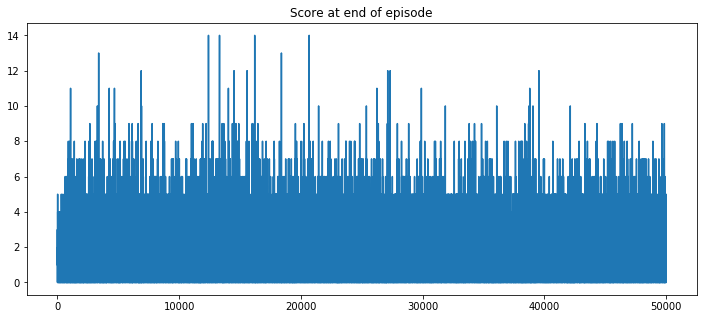

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Score at end of episode")
plt.plot(reward_total[:frames_total])
plt.show()

In [24]:
print("Average number of steps: {}". format(np.average(steps_total[:frames_total])))

Average number of steps: 229.59094


In [27]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average reward in last 100 episodes: {}". format(np.average(reward_total[num_episodes-100:num_episodes])))



Average number of steps=reward: 229.59094
Average reward in last 100 episodes: 1.61


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

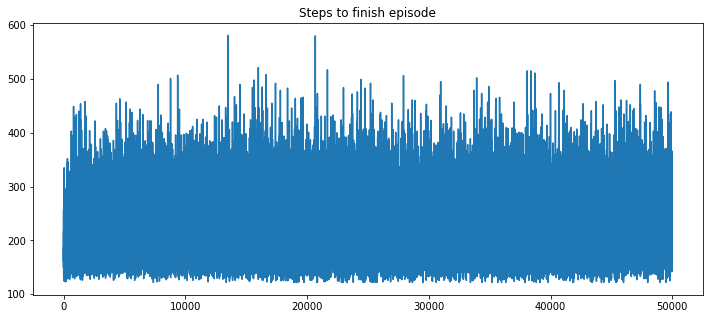

In [26]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total[:frames_total])
plt.show()